In [1]:
import mne
import bids
import mne_bids
from mne_bids import BIDSPath
import os
from pathlib import Path
import eeg_fmri_cleaning.GradientRemover as GradientRemover
import eeg_fmri_cleaning.utils as utils
import numpy as np
import pickle

# Builds the BIDS path because file naming is inconsistent

In [2]:
def parse_file_entities(filename):
    file = Path(filename).name
    basename, extension = os.path.splitext(file)
    entities = dict()
    entities['extension'] = extension
    entities['suffix'] = basename.split('_')[-1]
    for entity in basename.split('_')[:-1]:
        key, value = entity.split('-')

        if key == 'sub':
            key = 'subject'
        elif key == 'ses':
            key = 'session'
        elif key == 'acq':
            key = 'acquisition'
        elif key == 'run':
            value = int(value)
        elif key == 'desc':
            key = 'description'

        entities[key] = value
    return entities

class Envelope:
    def __init__(self, raw):
        self.raw = raw
        self.frequencies = dict()
    def extract_eeg_band_envelope(self):
        self.frequencies = {
            'delta': (0.5, 4),
            'low_theta': (4, 6),
            'high_theta': (6, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'low_gamma': (30, 40)
        }
        envelope_list = list()
        for freqs in self.frequencies.values():
            filtered = raw.copy().filter(*freqs)
            envelope_list.append(
                filtered.copy().apply_hilbert(envelope = True).get_data()
                )

        self.envelopes = np.stack(envelope_list, axis = -1)

        return self

    def extract_custom_envelope(self,
                                low = 1, 
                                high = 40, 
                                step = 1):

        envelope_list = list()
        for i, low_frequency in enumerate(range(low, high, step)):
            self.frequencies[f'narrow_band_{i+1}'] = (low_frequency, low_frequency + step)
            high_frequency = low_frequency + step
            filtered = raw.copy().filter(low_frequency, high_frequency)
            envelope_list.append(
                filtered.copy().apply_hilbert(envelope = True).get_data()
                )
            self.envelopes = np.stack(envelope_list, axis = -1)

        return self
    
    def save(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self, file)

In [3]:
derivatives_path = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/eeg_features_extraction')
raw_path = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_BV_EDF')
filename = 'sub-09_ses-01_task-checker_run-01_eeg.edf'

# Signal Envelope

In [7]:
%%capture
for filename in raw_path.iterdir():
    file_entities = parse_file_entities(filename)
    if task == 'checker' or task == 'rest':
        bids_path = BIDSPath(**file_entities, root=derivatives_path,
                                datatype='eeg')
        bids_path.mkdir()
        raw = mne.io.read_raw_edf(raw_path / filename, preload=True)
        envelope = Envelope(raw)
        bids_path.update(description = 'EEGbandsEnvelopes')
        bands_envelope_filename = os.path.splitext(bids_path.fpath)[0] + '.pkl'
        envelope.extract_eeg_band_envelope().save(bands_envelope_filename)
        custom_envelope_filename = os.path.splitext(bids_path.fpath)[0] + '_custom.pkl'
        envelope.extract_custom_envelope().save(custom_envelope_filename)

KeyboardInterrupt: 

# Check duration between fMRI acquisition

In [4]:
raw = mne.io.read_raw_edf(raw_path / filename, preload=True)
raw.filter(1,45)
annotations = raw.annotations
gradient_trigger_name = GradientRemover.extract_gradient_trigger_name(raw)
gradient_onset = annotations.onset[np.where(annotations.description == gradient_trigger_name)]
duration_between_gradients = np.diff(gradient_onset)
print(f'Median duration between gradients: {np.median(duration_between_gradients)}')
print(f'Mean duration between gradients: {np.mean(duration_between_gradients)}')
print(f'Std duration between gradients: {np.std(duration_between_gradients)}')

Extracting EDF parameters from /projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_BV_EDF/sub-09_ses-01_task-checker_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 72749  =      0.000 ...   290.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 s)

Median duration between gradients: 2.0999999999999943
Mean duration between gradients: 2.1
Std duration between gradients: 9.162237312259528e-15


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


# Sanity Check Stockwell

In [ ]:
channel_types = utils.map_channel_type(raw)
raw = utils.set_channel_types(raw, channel_types)
raw.set_montage('easycap-M1')
events, event_id = mne.events_from_annotations(raw)
picked_events = mne.pick_events(events, include=[event_id[gradient_trigger_name]])
picked_event_id = {gradient_trigger_name: event_id[gradient_trigger_name]}
epochs_gradient = mne.Epochs(raw, 
                             picked_events, 
                             picked_event_id, 
                             tmin=0.1, 
                             tmax=2.08, 
                             baseline=None,
                             preload=True)
epochs_gradient.copy().average().plot()
epochs_gradient.copy().average().plot_joint()
for method in ['multitaper', 'stockwell', 'morlet']:
    if method == 'stockwell':
        power = epochs_gradient.compute_tfr(freqs = [1,40], method=method, output = 'power')
    else:
        frequencies = np.arange(1,40,1)
        cycles = frequencies / 2
        power = epochs_gradient.compute_tfr(freqs = frequencies,
                                            n_cycles = cycles,
                                            method=method,
                                            average = True,
                                            n_jobs = -1,)
    power.plot_topo(baseline = (0, 0.1), mode = 'logratio', title = f'Average power {method}')
    power.plot(mode = 'logratio', baseline = (0,0.1), title = f'Average power {method}')
                            


In [28]:
%%capture
def create_morlet_epochs(raw):
    channel_types = utils.map_channel_type(raw)
    raw = utils.set_channel_types(raw, channel_types)
    raw.set_montage('easycap-M1')
    events, event_id = mne.events_from_annotations(raw)
    picked_events = mne.pick_events(events, include=[event_id[gradient_trigger_name]])
    picked_event_id = {gradient_trigger_name: event_id[gradient_trigger_name]}
    epochs_gradient = mne.Epochs(raw, 
                                picked_events, 
                                picked_event_id, 
                                tmin=0.1, 
                                tmax=2.08, 
                                baseline=None,
                                event_repeated = 'drop',
                                preload=True)
    frequencies = np.linspace(1,40,40)
    cycles = frequencies / 2
    power = epochs_gradient.compute_tfr(freqs = frequencies, 
                                        n_cycles = cycles,
                                        method='morlet',
                                        average = False,
                                        return_itc = False,
                                        n_jobs = -1)
    
    return power

for filename in raw_path.iterdir():
    file_entities = parse_file_entities(filename)
    if file_entities['task'] == 'checker' or file_entities['task'] == 'rest':
        bids_path = BIDSPath(**file_entities, 
                             root=derivatives_path,
                             datatype='eeg')
        bids_path.update(description = 'MorletTFR')
        bids_path.mkdir()
        raw = mne.io.read_raw_edf(raw_path / filename, preload=True)
        power = create_morlet_epochs(raw)
        saving_path = os.path.splitext(bids_path.fpath)[0] + '.fif'
        power.save(saving_path, overwrite=True)

KeyboardInterrupt: 

# Algo test

In [3]:
derivatives_path = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/eeg_features_extraction')
raw_path = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_BV_EDF')
filename = 'sub-09_ses-01_task-checker_run-01_eeg.edf'

In [42]:
import envelope_and_TF_pipeline as pipeline
cropped_raw = pipeline.specific_crop(raw)
eeg_features = pipeline.EEGfeatures(cropped_raw)

eeg_features.extract_eeg_band_envelope()
eeg_features.save('test.pkl')

Used Annotations descriptions: ['New Segment', 'R', 'R128', 'S  1', 'S 10', 'S 11', 'S 12', 'S 25', 'S 26', 'S 27', 'S 99', 'Sync On', 'TEND', 'TPEAK', 'TSTART', 'Time 0', 'Userdefined Artifact']
Used Annotations descriptions: ['New Segment', 'R', 'R128', 'S  1', 'S 10', 'S 11', 'S 12', 'S 25', 'S 26', 'S 27', 'S 99', 'Sync On', 'TEND', 'TPEAK', 'TSTART', 'Time 0', 'Userdefined Artifact']
cropping from 35.544 to 241.344
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw da

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 413 samples (1.652 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 111 samples (0.444 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


saving into test.pkl


In [43]:
import pickle
with open('test.pkl', 'rb') as file:
    eeg_features = pickle.load(file)

In [45]:
eeg_features.keys()

dict_keys(['channel_names', 'times', 'frequencies', 'feature', 'feature_info'])

# Demo envelope

Extracting EDF parameters from /projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_BV_EDF/sub-09_ses-01_task-checker_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 72749  =      0.000 ...   290.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 413 samples (1.652 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 413 samples (1.652 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


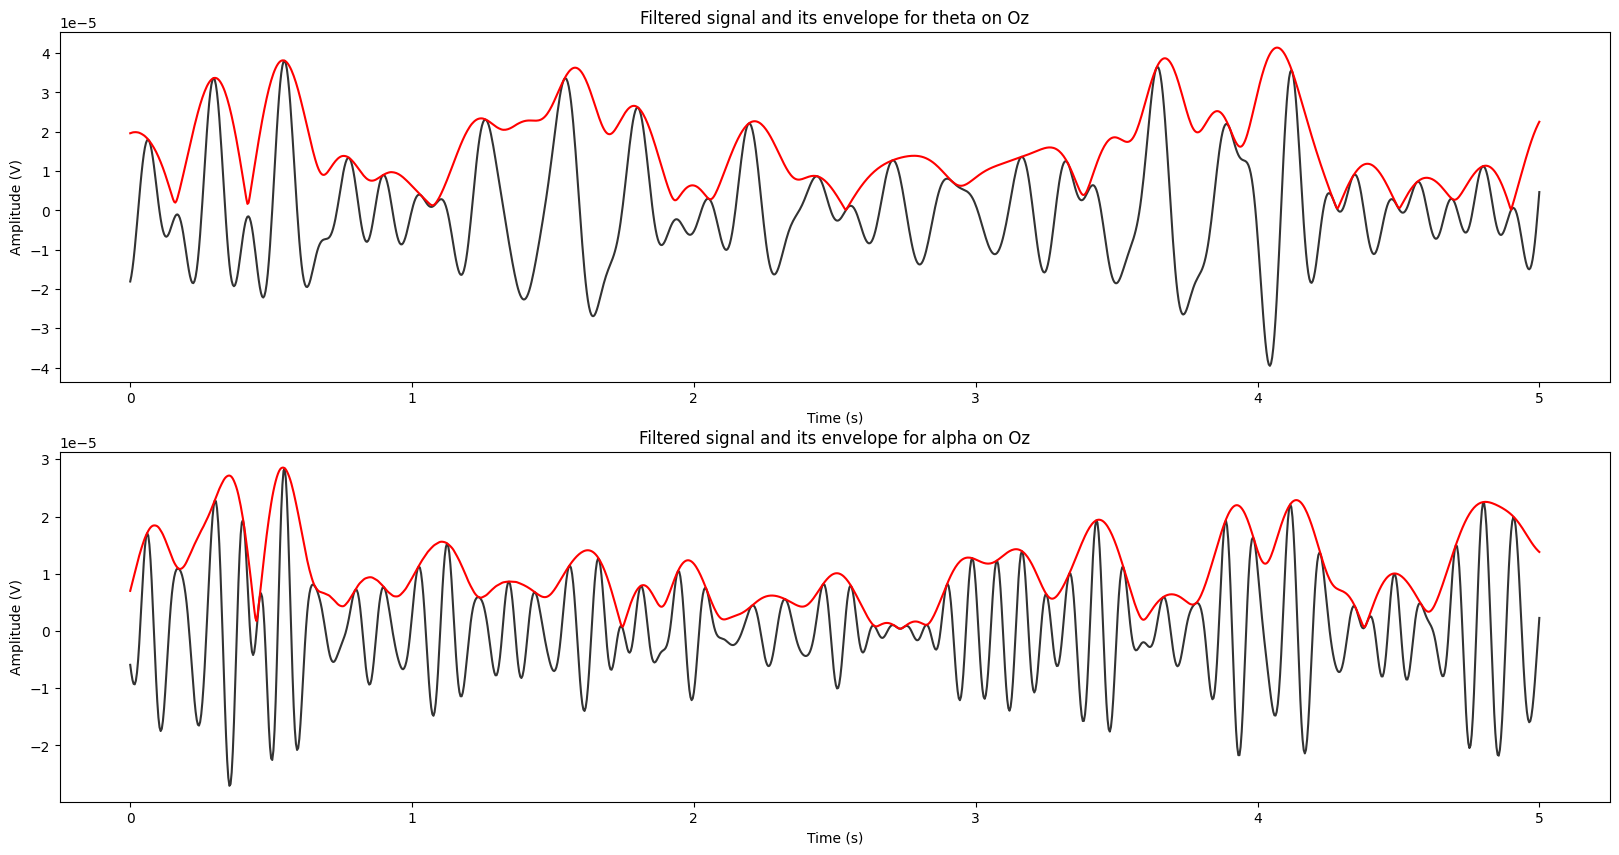

In [4]:
import mne
import bids
import mne_bids
from mne_bids import BIDSPath
import os
from pathlib import Path
import eeg_fmri_cleaning.GradientRemover as GradientRemover
import eeg_fmri_cleaning.utils as utils
import numpy as np
import pickle
import matplotlib.pyplot as plt
raw = mne.io.read_raw_edf(raw_path / filename, preload=True)
eeg_bands = {
    'theta': (4, 8),
    'alpha': (8, 13),
}
channel = 'Oz'
fig, ax = plt.subplots(2,1, figsize = (20,10))
for i, (band_name, band_value) in enumerate(eeg_bands.items()):
    data_array = raw.copy().crop(35,40).pick(channel).get_data()
    times = raw.copy().crop(35,40).times
    filtered_array = raw.copy().filter(*band_value).crop(35,40).pick(channel).get_data()
    envelope_array = raw.copy().filter(*band_value).apply_hilbert(envelope = True).crop(35,40).pick(channel).get_data()
    ax[i].plot(times,
             filtered_array.T,
                label = 'Filtered',
                color = 'black',
                alpha = 0.8)
    ax[i].plot(times,
             envelope_array.T,
                label = 'Envelope',
                color = 'red')
    ax[i].set_ylabel('Amplitude (V)')
    ax[i].set_xlabel('Time (s)')
    ax[i].set_title(f'Filtered signal and its envelope for {band_name} on {channel}')



In [7]:
raw_TFR = raw.compute_tfr(freqs = np.arange(1,40,1), 
                          method='morlet', 
                          n_cycles = np.arange(1,40,1)/2, 
                          n_jobs = -1,
                          tmin = 35,
                          tmax = 40)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  64 | elapsed:    5.1s remaining:   18.3s
[Parallel(n_jobs=-1)]: Done  27 out of  64 | elapsed:    5.7s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  40 out of  64 | elapsed:    6.0s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  53 out of  64 | elapsed:    6.1s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    6.1s finished


In [10]:
isinstance(raw, mne.io.BaseRaw)

True

In [45]:
import re
from typing import Any# getting numbers from string 

def extract_number_in_string(string: str) -> int:
    """Extract digit values in a string.

    Args:
        string (str): The string for which the digits will be extracted.

    Returns:
        int: The extracted digits
    """
    temp = re.findall(r'\d+', string)
    number = list(map(int, temp))
    return number[0]

def extract_channel_laterality(channel: str) -> str:
    """Extract the laterality of the channel.
    
    According to the international eeg standard, the laterality of channels
    are defined by the number. If the number is even, the channel is on the right
    side of the head, if the number is odd, the channel is on the left side of the
    head. If the channel has the letter 'z' instead of a number, 
    the channel is located on the midline.

    Args:
        channel (str): The name of the channel.

    Returns:
        str: The laterality of the corresponding channel.
    """
    if 'z' in channel.lower():
        return 'midline'
    else:
        number = extract_number_in_string(channel)
        if number % 2 == 0:
            return 'right'
        else:
            return 'left'

def extract_channel_anatomy(channel: str) -> str:
    """Extract the anatomical location of the channel from its name.

    Args:
        channel (str): The name of the channel.

    Returns:
        str: The anatomical location of the channel.
    """
    letter_anatomy_relationship = {
        'F': 'frontal',
        'C': 'central',
        'P': 'parietal',
        'O': 'occipital',
        'T': 'temporal',
        'Fp': 'frontopolar',
        'AF': 'anterior-frontal',
        'FC': 'fronto-central',
        'CP': 'centro-parietal',
        'PO': 'parieto-occipital',
        'FT': 'fronto-temporal',
        'TP': 'temporo-parietal',
    }
    pattern = re.findall(r'[a-zA-Z]+', channel)[0]
    pattern = pattern.replace('z', '')
    return letter_anatomy_relationship.get(pattern)

def extract_location(channels: list[str]) -> dict[str, list[Any]]:
    
    location = {
        'index': list(),
        'channel_name': list(),
        'anatomy': list(),
        'laterality': list()
    }
    for channel in channels:
        if 'ecg' in channel.lower() or 'eog' in channel.lower():
            continue
        info = (
            channels.index(channel),
            channel,
            extract_channel_anatomy(channel),
            extract_channel_laterality(channel)
        )
        
        for key, value in zip(location.keys(), info):
            location[key].append(value)

    return location

In [46]:
loc = extract_location(channels)

In [11]:
import pickle
with open('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/eeg_features_extraction/sub-19/ses-01/eeg/sub-19_ses-01_task-checker_run-01_desc-MorletTFR_eeg.pkl', 'rb') as file:
    envelope = pickle.load(file)
envelope

{'channels_info': {'index': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61],
  'channel_name': ['Fp1',
   'Fp2',
   'F3',
   'F4',
   'C3',
   'C4',
   'P3',
   'P4',
   'O1',
   'O2',
   'F7',
   'F8',
   'T7',
   'T8',
   'P7',
   'P8',
   'Fz',
   'Cz',
   'Pz',
   'Oz',
   'FC1',
   'FC2',
   'CP1',
   'CP2',
   'FC5',
   'FC6',
   'CP5',
   'CP6',
   'TP9',
   'TP10',
   'POz',
   'F1',
   'F2',
   'C1',
   'C2',
   'P1',
   'P2',
   'AF3',
   'AF4',
   'FC3',
   'FC4',
   'CP3',
   'CP4',
   'PO3',
   'PO4',
   'F5',
   'F6',
   'C5',
   'C6',
   'P5',
   'P6',
   'AF7',
   'AF8',
   'FT7',
   'FT8',
   'TP7',
   'TP8',

In [16]:
print(envelope.get('times').shape)
print(envelope.get('feature').shape)
print(envelope.get('frequencies').shape)

(151201,)
(64, 151201, 5)
(5, 2)


In [20]:
print(len(envelope.get('channels_info').get('channel_name')))
print()

{'index': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61],
 'channel_name': ['Fp1',
  'Fp2',
  'F3',
  'F4',
  'C3',
  'C4',
  'P3',
  'P4',
  'O1',
  'O2',
  'F7',
  'F8',
  'T7',
  'T8',
  'P7',
  'P8',
  'Fz',
  'Cz',
  'Pz',
  'Oz',
  'FC1',
  'FC2',
  'CP1',
  'CP2',
  'FC5',
  'FC6',
  'CP5',
  'CP6',
  'TP9',
  'TP10',
  'POz',
  'F1',
  'F2',
  'C1',
  'C2',
  'P1',
  'P2',
  'AF3',
  'AF4',
  'FC3',
  'FC4',
  'CP3',
  'CP4',
  'PO3',
  'PO4',
  'F5',
  'F6',
  'C5',
  'C6',
  'P5',
  'P6',
  'AF7',
  'AF8',
  'FT7',
  'FT8',
  'TP7',
  'TP8',
  'PO7',
  'PO8',
  'Fpz',
  'CPz'],
 'anatomy': ['frontopolar',
  'frontopolar',
  'frontal',
  'frontal',
  'central',
  'central',


In [9]:
envelope

{'channels_info': {'index': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61],
  'channel_name': ['Fp1',
   'Fp2',
   'F3',
   'F4',
   'C3',
   'C4',
   'P3',
   'P4',
   'O1',
   'O2',
   'F7',
   'F8',
   'T7',
   'T8',
   'P7',
   'P8',
   'Fz',
   'Cz',
   'Pz',
   'Oz',
   'FC1',
   'FC2',
   'CP1',
   'CP2',
   'FC5',
   'FC6',
   'CP5',
   'CP6',
   'TP9',
   'TP10',
   'POz',
   'F1',
   'F2',
   'C1',
   'C2',
   'P1',
   'P2',
   'AF3',
   'AF4',
   'FC3',
   'FC4',
   'CP3',
   'CP4',
   'PO3',
   'PO4',
   'F5',
   'F6',
   'C5',
   'C6',
   'P5',
   'P6',
   'AF7',
   'AF8',
   'FT7',
   'FT8',
   'TP7',
   'TP8',

In [96]:
raw = mne.io.read_raw_edf(raw_path / filename, preload=True)
#raw.filter(1,40)
array = raw.get_data()

Extracting EDF parameters from /projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_BV_EDF/sub-09_ses-01_task-checker_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 72749  =      0.000 ...   290.996 secs...


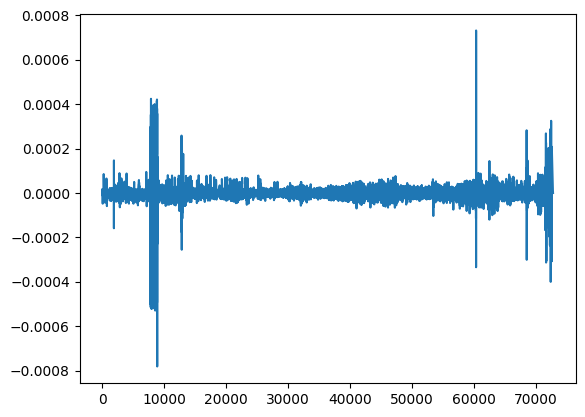

In [90]:
plt.plot(array[0,:].T)

In [79]:
array.shape[1]

3651

In [80]:
envelope.get('feature').shape

(64, 40, 151201)

In [1]:
import mne
import bids
import mne_bids
from mne_bids import BIDSPath
import os
from pathlib import Path
import eeg_fmri_cleaning.GradientRemover as GradientRemover
import eeg_fmri_cleaning.utils as utils
import numpy as np
import pickle
import matplotlib.pyplot as plt
subject = '01'
derivatives_path = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/eeg_features_extraction')
raw_path = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_BV_EDF')
filename = f'sub-{subject}_ses-01_task-checker_run-01_eeg.edf'
raw = mne.io.read_raw_edf(raw_path / filename, preload=True)
envelope_path = derivatives_path / f'sub-{subject}/ses-01/eeg/sub-{subject}_ses-01_task-checker_run-01_desc-MorletTFR_eeg.pkl'
with open (envelope_path, 'rb') as file:
    envelope = pickle.load(file)
array = raw.get_data()
onsets = raw.annotations.onset[np.where(raw.annotations.description == 'R128')]

Extracting EDF parameters from /projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_BV_EDF/sub-01_ses-01_task-checker_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 60499  =      0.000 ...   241.996 secs...


from 3 to 10


/tmp/ipykernel_2222660/1840794926.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(plt.gca().get_xticks() / raw.info['sfreq'])


Text(0, 0.5, 'EEG Amplitude (V)')

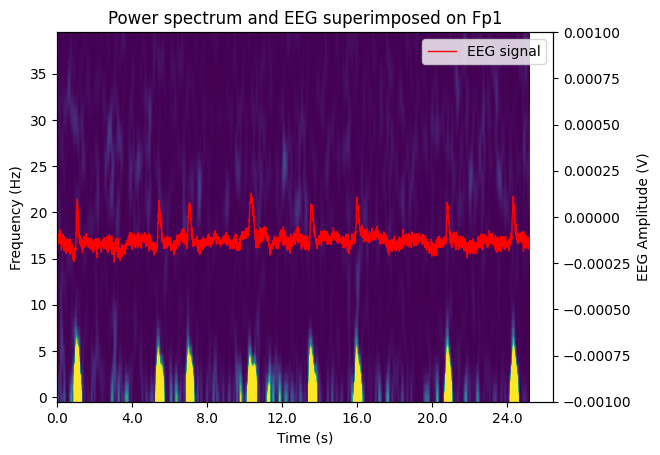

Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Fp1 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 106 significant peaks
Number of EOG events detected: 106
Not setting metadata
106 matching events found
No baseline correction applied
Using data from preloaded Raw for 106 events and 251 original time points ...
0 bad epochs dropped
Applying baseline corr

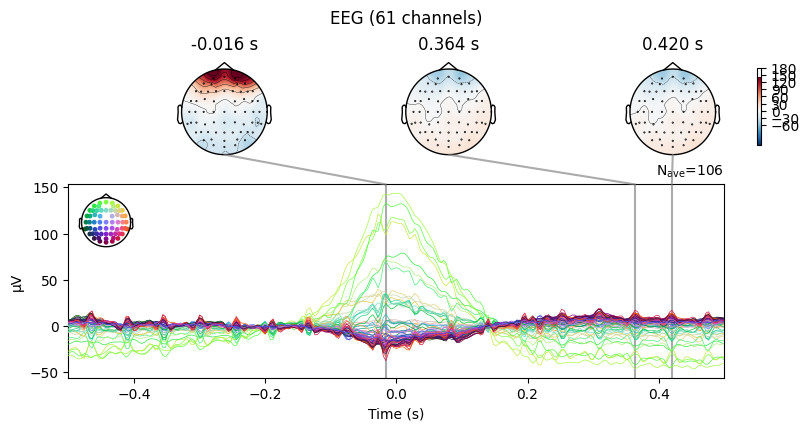

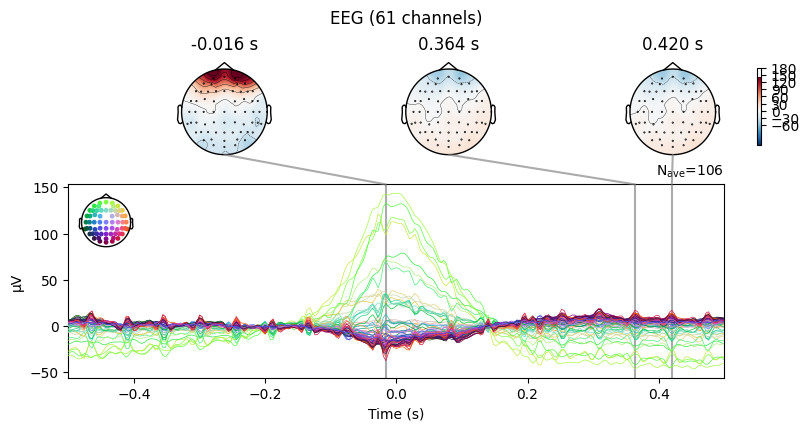

In [4]:
map = utils.map_channel_type(raw)
raw.set_channel_types(map)
montage = mne.channels.make_standard_montage('easycap-M1')
raw.set_montage(montage)
eog_evoked = mne.preprocessing.create_eog_epochs(raw, ch_name = ['Fp1','Fp2']).average()
eog_evoked.apply_baseline((None, None))
eog_evoked.plot_joint()

Running EOG SSP computation
Using EOG channels: EOGL, EOGU
EOG channel index for this subject is: [62 63]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOGU for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 103 significant peaks
Number of EOG events detected: 103
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Adding projection: eeg--0.200-0.200-PCA-01 (exp var=97.3%)
Done.
1 projection items deactivated


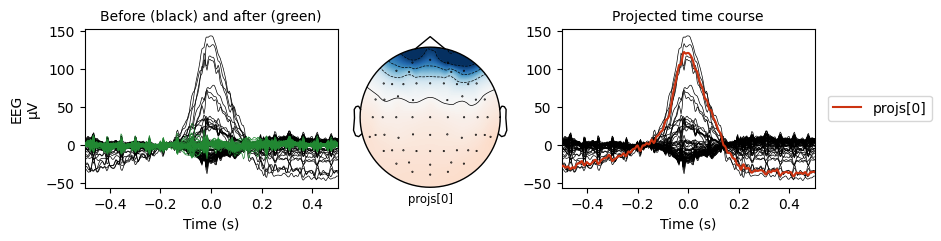

Text(0.5, 0.98, 'EOG projectors')

In [6]:
eog_projs, _ = mne.preprocessing.compute_proj_eog(
    raw, n_eeg=1, reject=None, no_proj=True
)
fig = mne.viz.plot_projs_joint(eog_projs, eog_evoked)
fig.suptitle("EOG projectors")

/tmp/ipykernel_2222660/390692070.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(plt.gca().get_xticks() / raw.info['sfreq'])


Text(0.5, 1.0, 'EEG signal before and after blink removal (SSP projection)')

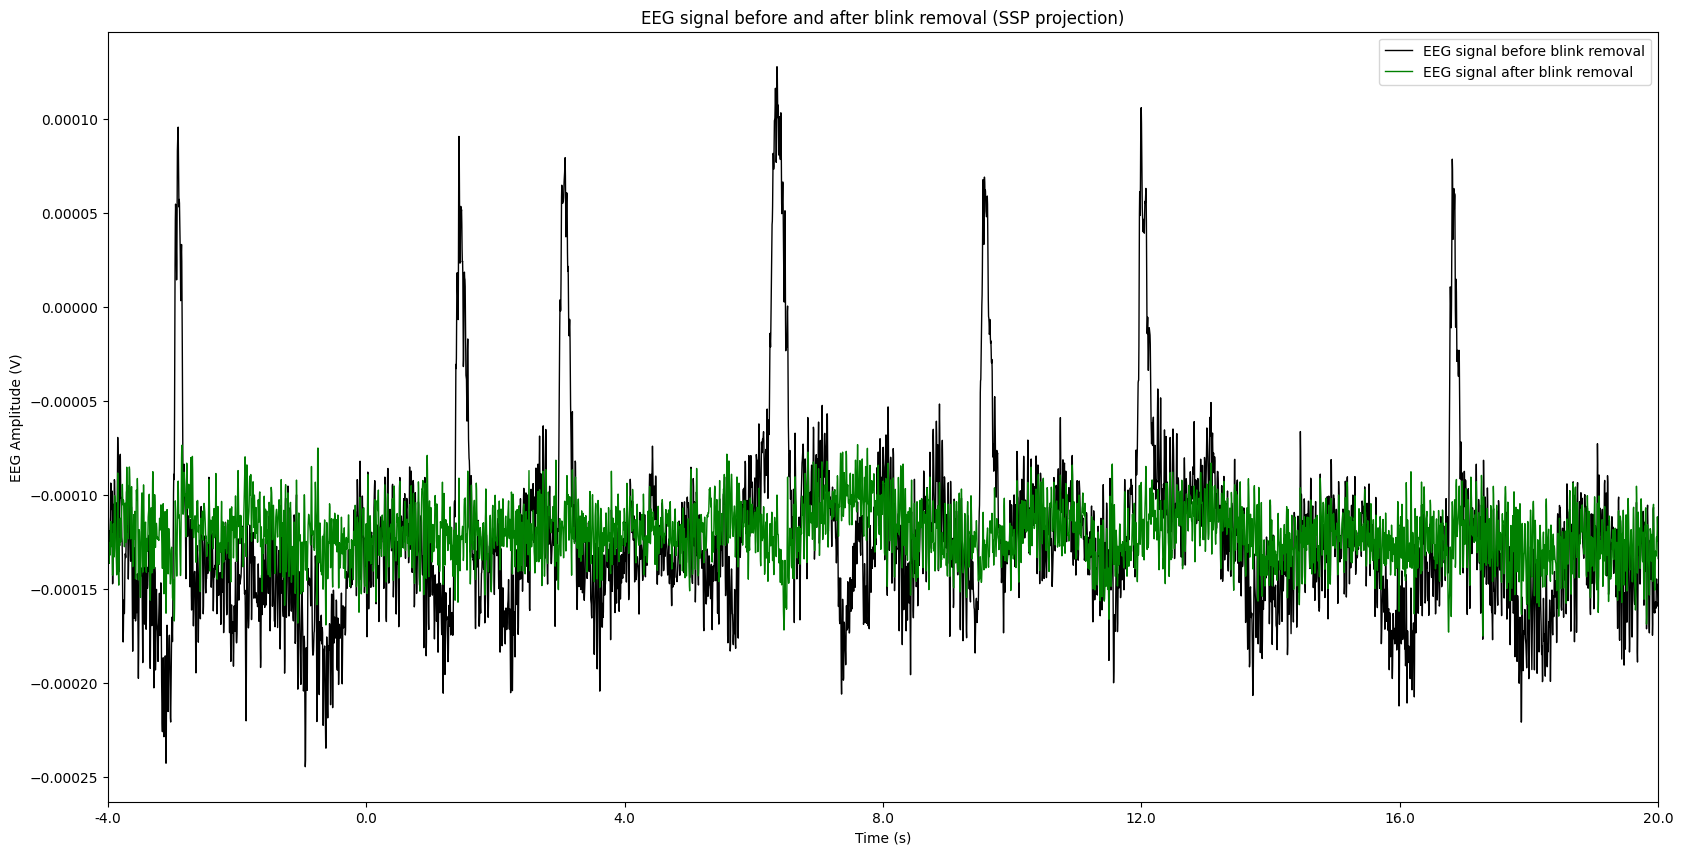

In [13]:
#array_after = raw.add_proj(eog_projs).apply_proj().get_data()
plt.figure(figsize = (20,10))
plt.plot(array[ch,start_array:stop_array], color = 'black', linewidth = 1, label = 'EEG signal before blink removal')
plt.plot(array_after[ch,start_array:stop_array], color = 'green', linewidth = 1, label = 'EEG signal after blink removal')
plt.legend()
plt.gca().set_xticklabels(plt.gca().get_xticks() / raw.info['sfreq'])
plt.gca().set_ylabel('EEG Amplitude (V)')
plt.gca().set_xlabel('Time (s)')
plt.xlim(0, 6000)
plt.title('EEG signal before and after blink removal (SSP projection)')

In [131]:
envelope_checker = derivatives_path / 'sub-09/ses-01/eeg/sub-09_ses-01_task-checker_run-01_desc-EEGbandsEnvelopes_eeg.pkl'
envelope_rest = derivatives_path / 'sub-09/ses-01/eeg/sub-09_ses-01_task-rest_run-01_desc-EEGbandsEnvelopes_eeg.pkl'

with open (envelope_checker, 'rb') as file:
    envelope_checker = pickle.load(file)

with open (envelope_rest, 'rb') as file:
    envelope_rest = pickle.load(file)


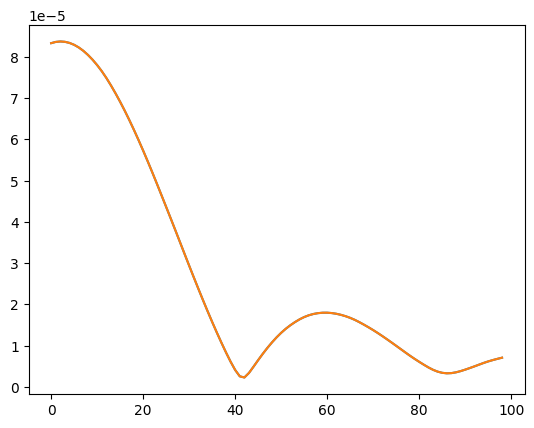

In [134]:
plt.plot(envelope_checker.get('feature')[0,1:100,1])
plt.plot(envelope_rest.get('feature')[0,1:100,1])

# CST

In [5]:
import bids
import mne
import mne_bids
from pathlib import Path

In [13]:
p = Path('/data2/Projects/NKI_RS2/MoBI/eeg_preprocessing_cst/data/annotated_eeg_data/calibration_data/eeg_data')
for file in p.rglob(pattern='*.fif'):
    print(file)


/data2/Projects/NKI_RS2/MoBI/eeg_preprocessing_cst/data/annotated_eeg_data/calibration_data/eeg_data/sub-M10971678/ses-MOBI1A/sub-M10971678_ses-MOBI1A_run-001_eeg.fif
/data2/Projects/NKI_RS2/MoBI/eeg_preprocessing_cst/data/annotated_eeg_data/calibration_data/eeg_data/sub-M10926757/ses-MOBI1A/sub-M10926757_ses-MOBI1A_run-001_eeg.fif
/data2/Projects/NKI_RS2/MoBI/eeg_preprocessing_cst/data/annotated_eeg_data/calibration_data/eeg_data/sub-M10939764/ses-MOBI1A/sub-M10939764_ses-MOBI1A_run-001_eeg.fif
/data2/Projects/NKI_RS2/MoBI/eeg_preprocessing_cst/data/annotated_eeg_data/calibration_data/eeg_data/sub-M10929258/ses-MOBI1A/sub-M10929258_ses-MOBI1A_run-001_eeg.fif
/data2/Projects/NKI_RS2/MoBI/eeg_preprocessing_cst/data/annotated_eeg_data/calibration_data/eeg_data/sub-M10983277/ses-MOBI1A/sub-M10983277_ses-MOBI1A_run-001_eeg.fif
/data2/Projects/NKI_RS2/MoBI/eeg_preprocessing_cst/data/annotated_eeg_data/calibration_data/eeg_data/sub-M10960293/ses-MOBI1A/sub-M10960293_ses-MOBI1_run-001_eeg.fif

BIDSValidationError: 'dataset_description.json' is missing from project root. Every valid BIDS dataset must have this file.
Example contents of 'dataset_description.json': 
{"Name": "Example dataset", "BIDSVersion": "1.0.2"}

In [16]:
import os
def parse_file_entities(filename: str | os.PathLike) -> dict:
    file_only = Path(filename).name
    basename, extension = os.path.splitext(file_only)
    entities = dict()
    entities['extension'] = extension
    entities['suffix'] = basename.split('_')[-1]
    for entity in basename.split('_')[:-1]:
        key, value = entity.split('-')

        if key == 'sub':
            key = 'subject'
        elif key == 'ses':
            key = 'session'
        elif key == 'acq':
            key = 'acquisition'
        elif key == 'desc':
            key = 'description'

        entities[key] = value
    return entities
for file in p.rglob(pattern='*.fif'):
    print(parse_file_entities(file))

{'extension': '.fif', 'suffix': 'eeg', 'subject': 'M10971678', 'session': 'MOBI1A', 'run': '001'}
{'extension': '.fif', 'suffix': 'eeg', 'subject': 'M10926757', 'session': 'MOBI1A', 'run': '001'}
{'extension': '.fif', 'suffix': 'eeg', 'subject': 'M10939764', 'session': 'MOBI1A', 'run': '001'}
{'extension': '.fif', 'suffix': 'eeg', 'subject': 'M10929258', 'session': 'MOBI1A', 'run': '001'}
{'extension': '.fif', 'suffix': 'eeg', 'subject': 'M10983277', 'session': 'MOBI1A', 'run': '001'}
{'extension': '.fif', 'suffix': 'eeg', 'subject': 'M10960293', 'session': 'MOBI1', 'run': '001'}
{'extension': '.fif', 'suffix': 'eeg', 'subject': 'M10996957', 'session': 'MOBI1A', 'run': '001'}
{'extension': '.fif', 'suffix': 'eeg', 'subject': 'M10928478', 'session': 'MOBI1A', 'run': '001'}
{'extension': '.fif', 'suffix': 'eeg', 'subject': 'M10940584', 'session': 'MOBI1A', 'run': '001'}
{'extension': '.fif', 'suffix': 'eeg', 'subject': 'M10939077', 'session': 'MOBI1A', 'run': '001'}
{'extension': '.fif',

In [2]:
import envelope_and_TF_pipeline as pipeline
import mne
filename = '/projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_BV_EDF/sub-21_ses-01_task-checker_run-01_eeg.edf'
raw = mne.io.read_raw_edf(filename, preload=True)
raw = pipeline.extract_eeg_only(raw)

Extracting EDF parameters from /projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_BV_EDF/sub-21_ses-01_task-checker_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 75249  =      0.000 ...   300.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


In [3]:
raw.get_data().shape

(61, 75250)

In [5]:
len(raw.ch_names)

61

# Muscle Artifacts removal attempts

In [4]:
import mne
import bids
import mne_bids
from mne_bids import BIDSPath
import os
from pathlib import Path
import eeg_fmri_cleaning.GradientRemover as GradientRemover
import eeg_fmri_cleaning.utils as utils
import numpy as np
import pickle
import eeg_research.preprocessing.tools.artifacts_annotator as annotator
from eeg_research.preprocessing.tools.utils import *
import envelope_and_TF_pipeline as pipeline

In [5]:
def remove_muscle_by_ica(raw, nb_to_remove = 12):
    ica = mne.preprocessing.ICA(
    n_components=None, 
    method="picard",
    max_iter="auto", 
    random_state=9
    )
    ica.fit(raw)
    muscle_idx, scores = ica.find_bads_muscle(raw)
    if nb_to_remove:
        highest_scores = set(
            np.argpartition(
                scores, 
                -nb_to_remove
                )[-nb_to_remove:]
            )
        components_to_remove = list(set(muscle_idx).intersection(highest_scores))
    else: 
        components_to_remove = muscle_idx
    ica.apply(raw, exclude = components_to_remove)
    return raw

dir = Path("/Users/samuel/Desktop/DATA_EEG_NKI")
for file in dir.iterdir():
    try:
        raw = mne.io.read_raw_edf(file, preload=True)
        raw = pipeline.specific_crop(raw, margin = 0)
        channel_map = map_channel_type(raw)
        raw = set_channel_types(raw, channel_map)
        montage = mne.channels.make_standard_montage("easycap-M1")
        raw.set_montage(montage)
        raw.plot(title = f'{file} Before muscle removal')
        raw2 = remove_muscle_by_ica(raw, nb_to_remove = 12)
        raw2.plot(title = f'{file} After muscle removal', block = True)
    except Exception as e:
        raise(e)
    #    print(f'Error with file {file}')

Extracting EDF parameters from /Users/samuel/Desktop/DATA_EEG_NKI/sub-22_ses-02_task-checker_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 59249  =      0.000 ...   236.996 secs...
Used Annotations descriptions: ['New Segment', 'R', 'R128', 'S  1', 'S 10', 'S 11', 'S 12', 'S 25', 'S 26', 'S 27', 'S 99', 'Sync On', 'TEND', 'TPEAK', 'TSTART', 'Time 0', 'Userdefined Artifact']
Used Annotations descriptions: ['New Segment', 'R', 'R128', 'S  1', 'S 10', 'S 11', 'S 12', 'S 25', 'S 26', 'S 27', 'S 99', 'Sync On', 'TEND', 'TPEAK', 'TSTART', 'Time 0', 'Userdefined Artifact']
cropping from 27.716 to 233.516
Using pyopengl with version 3.1.6
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components


/var/folders/l3/myr9vj8933q4vwhkbvxcx6gc0000gn/T/ipykernel_14656/2371889466.py:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 10.6s.
Effective window size : 8.192 (s)
Applying ICA to Raw instance
    Transforming to ICA space (61 components)
    Zeroing out 4 ICA components
    Projecting back using 61 PCA components
Using pyopengl with version 3.1.6
Channels marked as bad:
none
Channels marked as bad:
none
Extracting EDF parameters from /Users/samuel/Desktop/DATA_EEG_NKI/sub-03_ses-01_task-checker_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 59999  =      0.000 ...   239.996 secs...
Used Annotations descriptions: ['New Segment', 'R', 'R128', 'S  1', 'S 10', 'S 11', 'S 12', 'S 25', 'S 26', 'S 27', 'S 99', 'Sync On', 'TEND', 'TPEAK', 'TSTART', 'Time 0', 'Userdefined Artifact']
Used Annotations descriptions: ['New Segment', 'R', 'R128', 'S  1', 'S 10', 'S 11', 'S 12', 'S 25', 'S 26', 'S 27', 'S 99', 'Sync On', 'TEND', 'TPEAK', 'TSTART', 'Time 0', 'Userdefined Artifact']
cropping from 28.524 to 234.32399999999998
Using pyopeng

/var/folders/l3/myr9vj8933q4vwhkbvxcx6gc0000gn/T/ipykernel_14656/2371889466.py:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 7.2s.
Effective window size : 8.192 (s)
Applying ICA to Raw instance
    Transforming to ICA space (61 components)
    Zeroing out 20 ICA components
    Projecting back using 61 PCA components
Using pyopengl with version 3.1.6


: 

# Blink Removal Comparison

In [7]:
file = '/Users/samuel/Desktop/DATA_EEG_NKI/sub-01_ses-01_task-checker_run-01_eeg.edf'
raw = mne.io.read_raw_edf(file, preload=True)
channel_map = map_channel_type(raw)
raw.set_channel_types(channel_map)
montage = mne.channels.make_standard_montage('easycap-M1')
raw.set_montage(montage)
ica = mne.preprocessing.ICA(
    n_components=61, 
    method="picard", 
    max_iter="auto", 
    random_state=97
    )
ica.fit(raw)
muscle_idx, scores = ica.find_bads_muscle(raw)


raw.filter(0.1,40)

#raw = pipeline.specific_crop(raw, margin = 2)
annotator_instance = annotator.ZscoreAnnotator(raw)
annotator_instance.detect_other(minimum_duration = None,
                                filtering = (None, None)
                                )

annotator_instance.annotate()
annotator_instance.raw.plot(block = True)

Extracting EDF parameters from /Users/samuel/Desktop/DATA_EEG_NKI/sub-01_ses-01_task-checker_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 60499  =      0.000 ...   241.996 secs...
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 61 components


/var/folders/l3/myr9vj8933q4vwhkbvxcx6gc0000gn/T/ipykernel_8355/1876787874.py:13: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 8.3s.
Effective window size : 8.192 (s)
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 8251 samples (33.004 s)

Filtering raw data in 1 contiguous segment

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Filter length: 1 samples (0.004 s)

Using pyopengl with version 3.1.6


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Channels marked as bad:
none


In [8]:
def remove_muscle_by_ica(raw, nb_to_remove = 12):
    ica = mne.preprocessing.ICA(
    n_components=None, 
    method="picard", 
    max_iter="auto", 
    random_state=9
    )
    ica.fit(raw)
    muscle_idx, scores = ica.find_bads_muscle(raw)
    highest_scores = set(
        np.argpartition(
            scores, 
            -nb_to_remove
            )[-nb_to_remove:]
        )
    components_to_remove = list(set(muscle_idx).intersection(highest_scores))
    ica.apply(raw, exclude = components_to_remove)
    return raw

file = '/Users/samuel/Desktop/DATA_EEG_NKI/sub-01_ses-01_task-checker_run-01_eeg.edf'
raw = mne.io.read_raw_edf(file, preload=True)
channel_map = map_channel_type(raw)
raw.set_channel_types(channel_map)
montage = mne.channels.make_standard_montage('easycap-M1')
raw.set_montage(montage)
raw = remove_muscle_by_ica(raw)
raw.plot()

Extracting EDF parameters from /Users/samuel/Desktop/DATA_EEG_NKI/sub-01_ses-01_task-checker_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 60499  =      0.000 ...   241.996 secs...
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components


/var/folders/l3/myr9vj8933q4vwhkbvxcx6gc0000gn/T/ipykernel_12574/529374416.py:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 8.1s.
Effective window size : 8.192 (s)
Applying ICA to Raw instance
    Transforming to ICA space (61 components)
    Zeroing out 12 ICA components
    Projecting back using 61 PCA components
Using pyopengl with version 3.1.6


Channels marked as bad:
none


In [28]:
set_max_nb_scores = set(np.argpartition(scores, -6)[-6:])
set_muscle_idx = set(muscle_idx)
list(set_muscle_idx.intersection(set_max_nb_scores))

[38, 17, 22, 56, 57, 58]

In [23]:
set_max_nb_scores

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60}

In [19]:
set_score_idx.

{0,
 1,
 2,
 4,
 16,
 17,
 18,
 21,
 22,
 25,
 28,
 29,
 32,
 37,
 38,
 41,
 42,
 44,
 45,
 47,
 48,
 52,
 54,
 56,
 57,
 58}